In [2]:
%matplotlib inline


Word Embeddings: Encoding Lexical Semantics
===========================================


In [34]:
# Author: Robert Guthrie

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(1)

In [35]:
word_to_ix = {"hello": 0, "world": 1}
embeds = nn.Embedding(2, 5)  # 2 words in vocab, 5 dimensional embeddings
lookup_tensor = torch.tensor([word_to_ix["hello"]], dtype=torch.long)
hello_embed = embeds(lookup_tensor)
print(word_to_ix["hello"],lookup_tensor,hello_embed)

0 tensor([0]) tensor([[ 0.6614,  0.2669,  0.0617,  0.6213, -0.4519]], grad_fn=<EmbeddingBackward>)


# 例子: N-Gram 语言模型
An Example: N-Gram Language Modeling
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Recall that in an n-gram language model, given a sequence of words
$w$, we want to compute

\begin{align}P(w_i | w_{i-1}, w_{i-2}, \dots, w_{i-n+1} )\end{align}

Where $w_i$ is the ith word of the sequence.

In this example, we will compute the loss function on some training
examples and update the parameters with backpropagation.


In [36]:
CONTEXT_SIZE = 3
EMBEDDING_DIM = 40
# 我们将使用 Shakespeare Sonnet 2
test_sentence = """When forty winters shall besiege thy brow,And dig deep trenches in thy beauty's field,
Thy youth's proud livery so gazed on now,Will be a totter'd weed of small worth held:Then being asked, where
all thy beauty lies, Where all the treasure of thy lusty days; To say, within thine own deep sunken eyes,
Were an all-eating shame, and thriftless praise. How much more praise deserv'd thy beauty's use,If thou couldst
answer 'This fair child of mine Shall sum my count, and make my old excuse,'Proving his beauty by succession thine!
This were to be new made when thou art old, And see thy blood warm when thou feel'st it cold. 
The Continuous Bag-of-Words model (CBOW) is frequently
used in NLP deep learning. It is a model that tries to
predict words given the context of a few words before 
and a few words after the target word. This is distinct 
from language modeling, since CBOW is not sequential and 
does not have to be probabilistic. Typcially, CBOW is used
to quickly train word embeddings, and these embeddings are
used to initialize the embeddings of some more complicated
model. Usually, this is referred to as pretraining embeddings.
It almost always helps performance a couple of percent. We are about to 
study the idea of a computational process.
Computational processes are abstract beings that inhabit computers.
As they evolve, processes manipulate other abstract things called data.
The evolution of a process is directed by a pattern of rules
called a program. People create programs to direct processes. In effect,
we conjure the spirits of the computer with our spells.To learn how to use 
PyTorch, begin with our Getting Started Tutorials. The 60-minute blitz is the 
most common starting point, and provides a broad view into how to use PyTorch 
from the basics all the way into constructing deep neural networks.Hello, everyone!
My name is and my English name is . I’m 15 years old. I’m a student in a very beautiful
school called Liangbing Middle School and I am in Class 1 Grade 7. My hometown Liangbing
is also a beautiful town. I’m very happy and I like to make friends with others. 
I also like singing but traveling is my favorite, I have been to many interesting
places in China but I haven’t been to other countries. What a pity! At school, 
I study Chinese,math, English, history, politics and so on. I like all of them.
I often help my teacher take care of my class and I think I am a good helper. 
I live with my parents and we go home on time every day.When I am at home, I often
help my mother do some housework and my mother said I am a good helper, too. My mother
is a barber.She cuts hair very well.She is kind.Many people like her. she often teaches
me the way of learning well, if you want to learn English well, here is some of my advice.
At first , you must read many articles and know many words, if you meet up with some new
words, you can look them up in the dictionary, you should know their meanings, how to 
read them and spell them. If you keep working hard, you will be successful. Then, you
ought to speak English as much as possible. Remember an old saying, Nothing is impossible
in the world if you put your heart into it. That’s all, thank you. Hello, Everybody!
I am very glad to stand here to give you my introduction. I am from Liangbing Middle School.
I am studying in Class 1,Grade 7. I love my hometown Liangbing because it’s a very beautiful
town. I have many hobbies, such as reading books, listening to music, surfing the Internet
and traveling. But listening to music is my favorite. I like pop music best. My idol are 
Jay. I am a lively girl. I like making friends and chatting with them. I can play the 
Chinese Kungfu. I passed all ten levels when I was in Grade 5.However, because of the
busy study, I don’t have any free time to practise it. What a pity! I am good at Math
and English and I like English better. In my opinion, it’s very easy and fun to learn
and use English and this contest is a great chance for me to learn English from others.
My saying is god help those who help themselves and I will never give up during my course
of learning. Now, after listening to my introduction, do you know me well?""".split()
# 我们应该对输入进行标记,但是我们将忽略它
# 建造一系列元组.  每个元组 ([ word_i-2, word_i-1 ], 都是目标单词)
# trigrams = [([test_sentence[i], test_sentence[i + 1]], test_sentence[i + CONTEXT_SIZE])
#             for i in range(len(test_sentence) - CONTEXT_SIZE)]

# 通用的上下文个数
trigrams = [([test_sentence[i + i0] for i0 in range(CONTEXT_SIZE)], test_sentence[i + CONTEXT_SIZE])
            for i in range(len(test_sentence) - CONTEXT_SIZE)]
# 输出前 3, 为了让你看到他的各式
print(trigrams[:3])
vocab = set(test_sentence)#创建一个无序不重复元素集,删除重复数据
word_to_ix = {word: i for i, word in enumerate(vocab)}#建立单词索引
#print(word_to_ix)

[(['When', 'forty', 'winters'], 'shall'), (['forty', 'winters', 'shall'], 'besiege'), (['winters', 'shall', 'besiege'], 'thy')]


In [37]:
class NGramLanguageModeler(nn.Module):
    def __init__(self, vocab_size, embedding_dim, context_size):
        '''(vocab_size:97 单词的个数, embedding_dim:10 定义单词的属性维度, context_size:2 上下文语境单词的个数)'''
        super(NGramLanguageModeler, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)
    def forward(self, inputs):
        embeds = self.embeddings(inputs).view((1, -1))
        out = F.relu(self.linear1(embeds))
        out = self.linear2(out)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs
model = NGramLanguageModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE)
print(model)

NGramLanguageModeler(
  (embeddings): Embedding(411, 40)
  (linear1): Linear(in_features=120, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=411, bias=True)
)


In [38]:
losses = []
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

for epoch in range(200):
    total_loss = torch.Tensor([0])
    for context, target in trigrams:

        # 步骤 1\. 准备好进入模型的数据 (例如将单词转换成整数索引,并将其封装在变量中)
        context_idxs = [word_to_ix[w] for w in context]# 上下文单词的索引
        context_var = autograd.Variable(torch.LongTensor(context_idxs))#封装

        # 步骤 2\. 回调 *积累* 梯度. 在进入一个实例前,需要将之前的实力梯度置零
        model.zero_grad()

        # 步骤 3\. 运行反向传播,得到单词的概率分布
        log_probs = model(context_var)

        # 步骤 4\. 计算损失函数. (再次注意, Torch需要将目标单词封装在变量中)
        loss = loss_function(log_probs, autograd.Variable(
            torch.LongTensor([word_to_ix[target]])))

        # 步骤 5\. 反向传播并更新梯度
        loss.backward()
        optimizer.step()

        total_loss += loss.data
    losses.append(total_loss.numpy()[0])

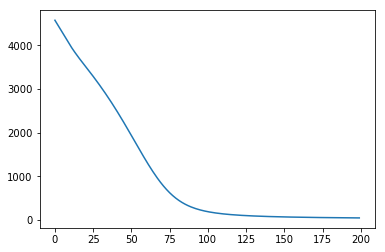

46.3028


In [39]:
plt.plot(losses)
plt.show()
print(losses[-1])  # 在训练集中每次迭代损失都会减小!

In [44]:
ix_to_word = {ix:w for w,ix in word_to_ix.items()}
def prediction(context_test):
    context_idxs = [word_to_ix[w] for w in context_test]# 上下文单词的索引
    context_test = autograd.Variable(torch.LongTensor(context_idxs))#封装
    log_probs = model(context_test)
    #print(log_probs)
    log_data = log_probs.data.numpy()[0]
    Idx = np.where(log_data == np.max(log_data))[0][0]
    #print(Idx,np.max(log_data))
    target_word = ix_to_word[Idx]
    return target_word
context_test = ['When','forty','winters']
sentence = ['When','forty','winters']
context_size = len(context_test)
for iter in range(200):
    #print(context_test)
    word = prediction(context_test)  
    sentence.append(word)
    context_test[0:context_size-1] = context_test[1:]
    context_test[-1] = word
    #print(context_test)
print(len(sentence))
print(" ".join(sentence))

203
When forty winters shall besiege thy brow,And dig deep trenches in thy beauty's field, Thy youth's proud livery so gazed on now,Will be a totter'd weed of small worth held:Then being asked, where all thy beauty lies, Where all the treasure of thy lusty days; To say, within thine own deep sunken eyes, Were an all-eating shame, and thriftless praise. How much more praise deserv'd thy beauty's use,If thou couldst answer 'This fair child of mine Shall sum my count, and make my old excuse,'Proving his beauty by succession thine! This were to be new made when thou art old, And see thy blood warm when thou feel'st it cold. The Continuous Bag-of-Words model (CBOW) is frequently used in NLP deep learning. It is a model that tries to predict words given the context of a few words after the target word. This is distinct from language modeling, since CBOW is not sequential and does not have to be probabilistic. Typcially, CBOW is used to quickly train word embeddings, and these embeddings are 

In [47]:
import difflib

text1_lines = (" ".join(test_sentence[0:203])).split()
print(len(text1_lines))
text2_lines = (" ".join(sentence)).split()
d = difflib.Differ()
diff = d.compare(text1_lines, text2_lines)

print("\n".join(list(diff)))

203
  When
  forty
  winters
  shall
  besiege
  thy
  brow,And
  dig
  deep
  trenches
  in
  thy
  beauty's
  field,
  Thy
  youth's
  proud
  livery
  so
  gazed
  on
  now,Will
  be
  a
  totter'd
  weed
  of
  small
  worth
  held:Then
  being
  asked,
  where
  all
  thy
  beauty
  lies,
  Where
  all
  the
  treasure
  of
  thy
  lusty
  days;
  To
  say,
  within
  thine
  own
  deep
  sunken
  eyes,
  Were
  an
  all-eating
  shame,
  and
  thriftless
  praise.
  How
  much
  more
  praise
  deserv'd
  thy
  beauty's
  use,If
  thou
  couldst
  answer
  'This
  fair
  child
  of
  mine
  Shall
  sum
  my
  count,
  and
  make
  my
  old
  excuse,'Proving
  his
  beauty
  by
  succession
  thine!
  This
  were
  to
  be
  new
  made
  when
  thou
  art
  old,
  And
  see
  thy
  blood
  warm
  when
  thou
  feel'st
  it
  cold.
  The
  Continuous
  Bag-of-Words
  model
  (CBOW)
  is
  frequently
  used
  in
  NLP
  deep
  learning.
  It
  is
  a
  model
  that
  tries
  to
  pr

In [18]:
context_test = ['And', 'dig','deep','trenches']
a = [word1 for word1 in context_test[1:]]
print(a)
print(context_test[1:])
c = [-10,-5,0,5,3,10,15,-20,25]

['dig', 'deep', 'trenches']
['dig', 'deep', 'trenches']


## 计算单词嵌入: 连续单词包
 Exercise: Computing Word Embeddings: Continuous Bag-of-Words
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

The Continuous Bag-of-Words model (CBOW) is frequently used in NLP deep
learning. It is a model that tries to predict words given the context of
a few words before and a few words after the target word. This is
distinct from language modeling, since CBOW is not sequential and does
not have to be probabilistic. Typcially, CBOW is used to quickly train
word embeddings, and these embeddings are used to initialize the
embeddings of some more complicated model. Usually, this is referred to
as *pretraining embeddings*. It almost always helps performance a couple
of percent.

The CBOW model is as follows. Given a target word $w_i$ and an
$N$ context window on each side, $w_{i-1}, \dots, w_{i-N}$
and $w_{i+1}, \dots, w_{i+N}$, referring to all context words
collectively as $C$, CBOW tries to minimize

\begin{align}-\log p(w_i | C) = -\log \text{Softmax}(A(\sum_{w \in C} q_w) + b)\end{align}

where $q_w$ is the embedding for word $w$.

Implement this model in Pytorch by filling in the class below. Some
tips:

* Think about which parameters you need to define.
* Make sure you know what shape each operation expects. Use .view() if you need to
  reshape.




In [19]:
CONTEXT_SIZE = 2  # 2 words to the left, 2 to the right
raw_text = """We are about to study the idea of a computational process.
Computational processes are abstract beings that inhabit computers.
As they evolve, processes manipulate other abstract things called data.
The evolution of a process is directed by a pattern of rules
called a program. People create programs to direct processes. In effect,
we conjure the spirits of the computer with our spells.""".split()

# By deriving a set from `raw_text`, we deduplicate the array
vocab = set(raw_text)
vocab_size = len(vocab)

word_to_ix = {word: i for i, word in enumerate(vocab)}
data = []
for i in range(2, len(raw_text) - 2):
    context = [raw_text[i - 2], raw_text[i - 1],
               raw_text[i + 1], raw_text[i + 2]]
    target = raw_text[i]
    data.append((context, target))
print(data[:5])


class CBOW(nn.Module):

    def __init__(self):
        pass

    def forward(self, inputs):
        pass

# create your model and train.  here are some functions to help you make
# the data ready for use by your module


def make_context_vector(context, word_to_ix):
    idxs = [word_to_ix[w] for w in context]
    return torch.tensor(idxs, dtype=torch.long)


make_context_vector(data[0][0], word_to_ix)  # example

[(['We', 'are', 'to', 'study'], 'about'), (['are', 'about', 'study', 'the'], 'to'), (['about', 'to', 'the', 'idea'], 'study'), (['to', 'study', 'idea', 'of'], 'the'), (['study', 'the', 'of', 'a'], 'idea')]


tensor([32, 14, 21,  8])